# Orthocorrection of KH-5 ARGON images

The purpose of this notebook is to ortho correct Declassified Intelligence Satellite Photography (DISP) from the KH-5 ARGON missions. The images are loaded one by one and corrected using the functions provided in geometry.

In [1]:
import os
import posixpath
import rasterio
import xarray as xr
import rioxarray
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import pandas as pd

# parallel computing
from dask.distributed import Client

# personnal packages
import utils.plots as plots
import geometry.internal_orientation as io
import geometry.external_orientation as eo

# to keep xarray quiet
# import warnings
# warnings.filterwarnings("ignore")

In [2]:
def set_env():
    os.environ["GS_NO_SIGN_REQUEST"] = "YES"

set_env()

client = Client(n_workers=4, threads_per_worker=2)
client.run(set_env)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 7.89 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53155,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:53178,Total threads: 2
Dashboard: http://127.0.0.1:53179/status,Memory: 1.97 GiB
Nanny: tcp://127.0.0.1:53158,


In [3]:
images_root = 'D:/OneDrive/Documents/Cours/4A/SFE/data/KH-5_ARGON_images'
products = []

for x in os.listdir(images_root):
    if os.path.isdir(posixpath.join(images_root, x)):
        products.append(x)
        
products

['DS09034A007MC018',
 'DS09034A007MC019',
 'DS09034A008MC019',
 'DS09034A008MC020',
 'DS09034A008MC021',
 'DS09034A008MC022',
 'DS09058A024MC012',
 'DS09058A024MC013']

# DS09058A024MC013

In [7]:
file = posixpath.join(images_root, "DS09058A024MC013", "DS09058A024MC013_a.tif")
raster = rioxarray.open_rasterio(file, chunks=True)
raster

c:\ProgramData\miniconda3\Lib\site-packages\rioxarray\_io.py:1143: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


<xarray.DataArray (band: 1, y: 19912, x: 19332)> Size: 385MB
dask.array<open_rasterio-890b347c846d082a08279604c8a0b0f9<this-array>, shape=(1, 19912, 19332), dtype=uint8, chunksize=(1, 6942, 19332), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 155kB 0.5 1.5 2.5 ... 1.933e+04 1.933e+04 1.933e+04
  * y            (y) float64 159kB 0.5 1.5 2.5 ... 1.991e+04 1.991e+04 1.991e+04
    spatial_ref  int32 4B 0
Attributes: (12/13)
    TIFFTAG_SOFTWARE:          Adobe Photoshop CC 2018 (Windows)
    TIFFTAG_DATETIME:          2019:12:03 22:13:38
    TIFFTAG_XRESOLUTION:       1432.3507
    TIFFTAG_YRESOLUTION:       1432.3507
    TIFFTAG_RESOLUTIONUNIT:    3 (pixels/cm)
    STATISTICS_APPROXIMATE:    YES
    ...                        ...
    STATISTICS_MEAN:           115.70980174446
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         99.755916419582
    STATISTICS_VALID_PERCENT:  100
    scale_factor:              1.0
    add_offset:                0.0

In [9]:
shx, shy = raster.shape[1:]

## IO

### Image, fiducial and photo coordinates

In [10]:
FMs = pd.DataFrame(
    [
        # top left corner
        [989, 375],
        # left side
        [1005, 3263],
        [1004, 6147],
        [1006, 9043],
        [1000, 11921],
        [1004, 14811],
        # bottom left corner
        [1012, 17698],
        # bottom side
        [3890, 17703],
        [6768, 17694],
        [9659, 17698],
        [12534, 17704],
        [15420, 17701],
        # bottom right corner
        [18326, 17704],
        # right side
        [18304, 14812],
        [18309, 11924],
        [18315, 9030],
        [18313, 6157],
        [18313, 3273],
        # top right corner
        [18293, 381],
        # top side
        [15427, 378],
        [12544, 376],
        [9650, 378],
        # missing point here
        [3897, 375],
    ],
    columns = ['x', 'y'],
    index=list(range(1, 23)) + [24]
)

FMs.loc[1, "side"] = "NW"
FMs.loc[2:6, "side"] = "W"
FMs.loc[7, "side"] = "SW"
FMs.loc[8:12, "side"] = "S"
FMs.loc[13, "side"] = "SE"
FMs.loc[14:18, "side"] = "E"
FMs.loc[19, "side"] = "NE"
FMs.loc[20:24, "side"] = "N"

xiW = FMs.loc[FMs["side"].apply(lambda x: x.__contains__("W")), "x"].mean() * 127/shx
etaS = FMs.loc[FMs["side"].apply(lambda x: x.__contains__("S")), "y"].mean() * 127/shy
xiE = FMs.loc[FMs["side"].apply(lambda x: x.__contains__("E")), "x"].mean() * 127/shx
etaN = FMs.loc[FMs["side"].apply(lambda x: x.__contains__("N")), "y"].mean() * 127/shy

FMs.loc[FMs["side"].apply(lambda x: x.__contains__("W")), "xi"] = xiW
FMs.loc[FMs["side"].apply(lambda x: x.__contains__("S")), "eta"] = etaS
FMs.loc[FMs["side"].apply(lambda x: x.__contains__("E")), "xi"] = xiE
FMs.loc[FMs["side"].apply(lambda x: x.__contains__("N")), "eta"] = etaN

delta_xi = (127 - xiW - (127 - xiE)) / 6
delta_eta = (127 - etaN - (127 - etaS)) /6

# FMs.loc[2:6, "eta"] = FMs.loc[2:6, "y"] * 127 / shy
# FMs.loc[8:12, "xi"] = FMs.loc[8:12, "x"] * 127 / shx
# FMs.loc[14:18, "eta"] = FMs.loc[14:18, "y"] * 127 / shy
# FMs.loc[20:24, "xi"] = FMs.loc[20:24, "x"] * 127 / shx

FMs.loc[2:6, "eta"] = etaN + delta_eta * np.array(range(1, 6))
FMs.loc[8:12, "xi"] = xiW + delta_xi * np.array(range(1, 6))
FMs.loc[14:18, "eta"] = etaN + delta_eta * np.array(range(5, 0, -1))
FMs.loc[20:24, "xi"] = xiW + delta_xi * np.array([5, 4, 3, 1]) # missing point here

x0, y0 = 127./2, 127./2
FMs.loc[:, ["xp", "yp"]] = [
    io.fiducial_to_photo_coordinates(FMs.loc[i, "xi"], FMs.loc[i, "eta"], x0, y0) for i in FMs.index
]
FMs.head()

,x,y,side,xi,eta,xp,yp
1,989,375,NW,6.396287,2.477766,-57.103713,-61.022234
2,1005,3263,W,6.396287,21.444902,-57.103713,-42.055098
3,1004,6147,W,6.396287,40.412039,-57.103713,-23.087961
4,1006,9043,W,6.396287,59.379176,-57.103713,-4.120824
5,1000,11921,W,6.396287,78.346312,-57.103713,14.846312


Text(0.5, 1.0, 'Photo coordinates [mm]')

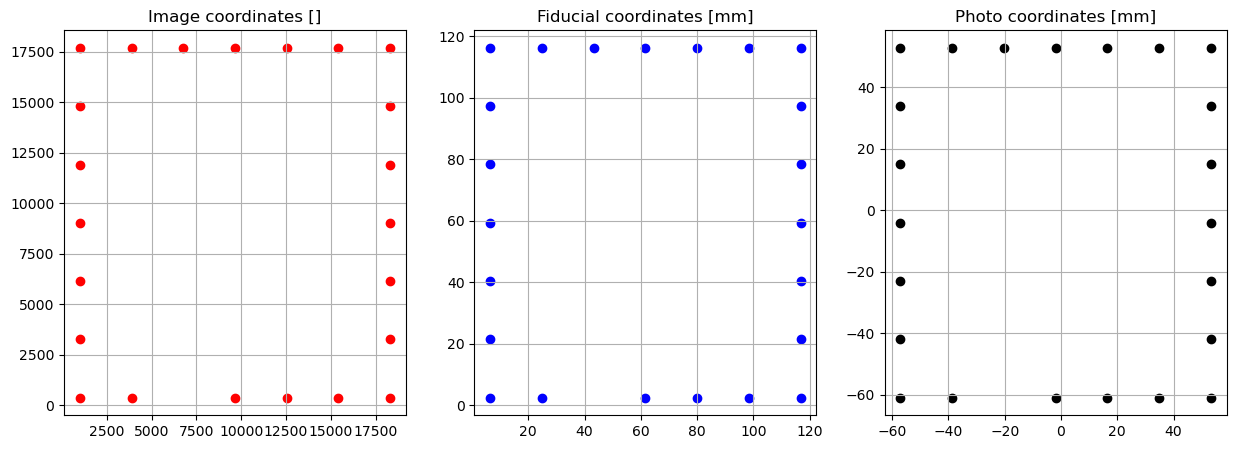

In [11]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
axs[0].scatter(FMs.x, FMs.y, color='r')
axs[0].grid()
axs[0].set_title('Image coordinates []')
axs[1].scatter(FMs.xi, FMs.eta, color='b')
axs[1].grid()
axs[1].set_title('Fiducial coordinates [mm]')
axs[2].scatter(FMs.xp, FMs.yp, color='k')
axs[2].grid()
axs[2].set_title('Photo coordinates [mm]')

In [12]:
# delta = 127./8

# FMs_fiducial_coords = np.array([
#     # [1, 1],
#     [1, 2],
#     [1, 3],
#     [1, 4],
#     [1, 5],
#     [1, 6],
#     # [1, 7],
#     [2, 7],
#     [3, 7],
#     [4, 7],
#     [5, 7],
#     [6, 7],
#     # [7, 7],
#     [7, 6],
#     [7, 5],
#     [7, 4],
#     [7, 3],
#     [7, 2],
#     # [7, 1],
#     [6, 1],
#     [5, 1],
#     [4, 1],
#     # [3, 1],
#     [2, 1],
# ]) * delta

# FMs_photo_coords = np.array(
#     [io.fiducial_to_photos_coordinates(FMs_fiducial_coords[i,  0], FMs_fiducial_coords[i, 1], 127/2, 127/2) for i in range(len(FMs_fiducial_coords))]
# )

### Transformation parameters
Finally, the image to fiducial coordinates transformation parameters are retrieved via an optimization process.
Several transformations and optimization methods are tested:

1. the affine transformation described in Molnar et al. (2021):
$$
\begin{pmatrix}
\xi\\
\eta
\end{pmatrix} = \begin{pmatrix}
\delta\xi\cos\alpha & \delta\eta\sin\alpha\\
-\delta\xi\sin\alpha & \delta\eta\cos\alpha
\end{pmatrix} \begin{pmatrix}
x - x_c\\
y - y_c
\end{pmatrix}
$$


where:
- $\xi$ and $\eta$ are the fiducial coordinates
- $x$ and $y$ are the image coordinates
- $\alpha$ is an angle
- $\delta\xi$ and $\delta\eta$ are the pixel size
- $x_c$ and $y_c$ are the location of the image coordinates system center.

The transformation is linear but the relation with the parameters is not (especially $\alpha$). Therefore, several optimization techniques are tested; the only satisfactory one is the Nelder-Mead algorithm (simplex).


0 0 0 0.0063780634793089595 0.006569418580591765
0.00011284928038408153 1.864246738408152e-05 -4.277637323551559e-06 0.006378427800801617 0.006569676113717639


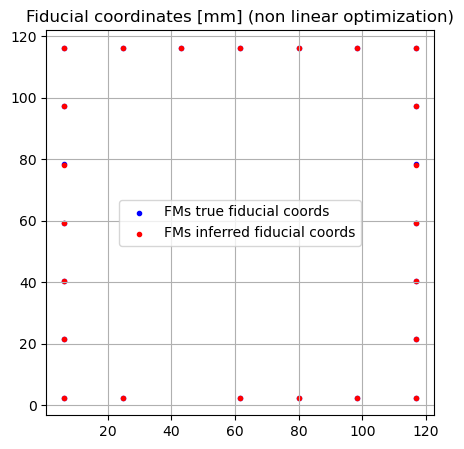

In [13]:
res = opt.minimize(
    io.objective_function_molnar,
    x0=[0, 0, 0, 127/shx, 127/shy],
    args=(FMs.loc[:, ("xi", "eta")].to_numpy(), FMs.loc[:, ("x", "y")].to_numpy()),
    method="Nelder-mead",
    options={"maxiter": 1000},
)
if res.success:
    params = res.x

    xc, yc, alpha, delta_eta, delta_xi = params[0], params[1], params[2], params[3], params[4]
    print(0, 0, 0, 127/shx, 127/shy)
    print(xc, yc, alpha, delta_eta, delta_xi)

    FMs_inferred_fiducial_coords = np.array([
        io.image_to_fiducial_coordinates_molnar(FMs.loc[i, "x"], FMs.loc[i, "y"], xc, yc, alpha, delta_eta, delta_xi) for i in FMs.index
    ])
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(FMs.xi, FMs.eta, marker=".", color="b", label='FMs true fiducial coords')
    ax.scatter(FMs_inferred_fiducial_coords[:, 0], FMs_inferred_fiducial_coords[:, 1], marker=".", color="r", label='FMs inferred fiducial coords')
    ax.grid()
    ax.legend()
    ax.set_title("Fiducial coordinates [mm] (non linear optimization)")
else:
    print(res)

2. A linear transformation of the plane:
$$
\begin{pmatrix}
\xi\\
\eta
\end{pmatrix} = \begin{pmatrix}
m_{11} & m_{12} \\
m_{21}  & m_{22} 
\end{pmatrix} \begin{pmatrix}
x\\
y
\end{pmatrix}
$$

Where:
- $\xi$ and $\eta$ are the fiducial coordinates
- $x$ and $y$ are the image coordinates
- $m_{11}\cdots m_{22}$ are a matrix coefficients.

This time, the relation between the parameters is fully linear, and allows for a linear least squares regression. Unfortunately, this method does not give good results (probably due to ill-conditioning), even with a Tikhonov regularization. Iterative methods, such as BFGS or Nelder-Mead are satisfactory.  

[[ 6.37898391e-03 -8.39882081e-07]
 [-7.58768117e-07  6.57020596e-03]]


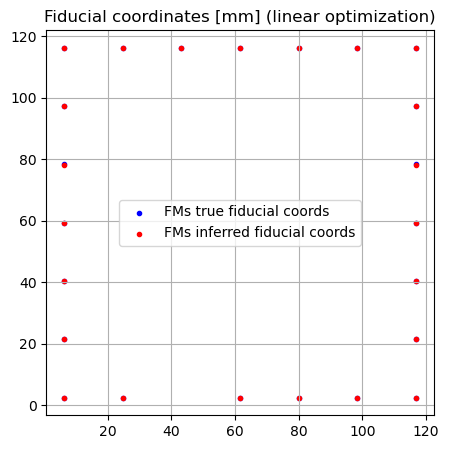

In [14]:
res = opt.minimize(
    io.objective_function_linear,
    x0=[127/shx, 0, 0, 127/shy],
    args=(FMs.loc[:, ("xi", "eta")].to_numpy(), FMs.loc[:, ("x", "y")].to_numpy()),
    method='Nelder-mead',
    options={"maxiter": 1000},
)

if res.success:
    matrix = res.x
    matrix = np.array([
        [matrix[0], matrix[1]],
        [matrix[2], matrix[3]]
    ])
    print(matrix)

    FMs_inferred_fiducial_coords = np.array([
        io.image_to_fiducial_coordinates_linear(FMs.loc[i, "x"], FMs.loc[i, "y"], matrix) for i in FMs.index
    ])

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(FMs.xi, FMs.eta, marker=".", color="b", label='FMs true fiducial coords')
    ax.scatter(FMs_inferred_fiducial_coords[:, 0], FMs_inferred_fiducial_coords[:, 1], marker=".", color="r", label='FMs inferred fiducial coords')
    ax.grid()
    ax.legend()
    ax.set_title("Fiducial coordinates [mm] (linear optimization)")
else:
    print(res)

3. An affine transformation of the plane:
$$
\begin{pmatrix}
\xi\\
\eta
\end{pmatrix} = \begin{pmatrix}
m_{11} & m_{12} \\
m_{21}  & m_{22} 
\end{pmatrix} \begin{pmatrix}
x\\
y
\end{pmatrix} + \begin{pmatrix}
x_t\\
y_t
\end{pmatrix}
$$

Where:
- $\xi$ and $\eta$ are the fiducial coordinates
- $x$ and $y$ are the image coordinates
- $m_{11}\cdots m_{22}$ are a matrix coefficients.
- $x_t$ and $y_t$ are a translation vector coefficients.

The inverse problem is solved using an iterative optimization method.  

[[ 6.37875068e-03 -9.23576592e-07]
 [-9.42935069e-07  6.57032499e-03]]
[ 1.37541988e-04 -4.03467806e-05]


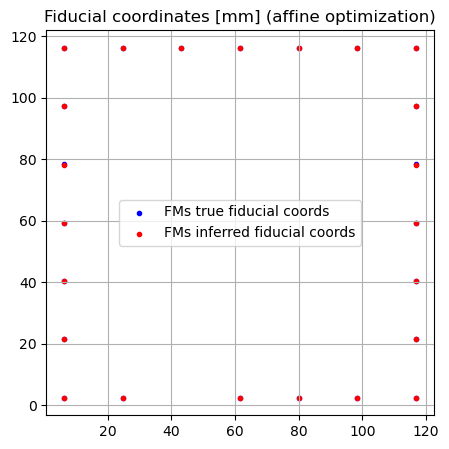

In [15]:
res = opt.minimize(
    io.objective_function_affine,
    x0=[127/shx, 0, 0, 127/shy, 0, 0],
    args=(FMs.loc[:, ("xi", "eta")].to_numpy(), FMs.loc[:, ("x", "y")].to_numpy()),
    method='Nelder-mead',
    options={"maxiter": 1000},
)
# res = opt.least_squares(
#     io.objective_function_affine,
#     x0=[127/shx, 0, 0, 127/shy, 0, 0],
#     args=(FMs_fiducial_coords, FMs_image_coords),
# )


if res.success:
    m11, m12, m21, m22, t1, t2 = res.x
    matrix = np.array([
        [m11, m12],
        [m21, m22]
    ])
    print(matrix)
    translation = np.array([t1, t2])
    print(translation)

    FMs_inferred_fiducial_coords = np.array([
        io.image_to_fiducial_coordinates_affine(FMs.loc[i, "x"], FMs.loc[i, "y"], matrix, translation) for i in FMs.index
    ])
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(FMs.xi, FMs.eta, marker=".", color="b", label='FMs true fiducial coords')
    ax.scatter(FMs_inferred_fiducial_coords[:, 0], FMs_inferred_fiducial_coords[:, 1], marker=".", color="r", label='FMs inferred fiducial coords')
    ax.grid()
    ax.legend()
    ax.set_title("Fiducial coordinates [mm] (affine optimization)")
else:
    print(res)

## EO

### GCPs loading and coordinates processing

1. GCPs identified in QGIS are loaded

In [16]:
file = posixpath.join(images_root, "DS09058A024MC013", "GCP.points")
GCPs = pd.read_csv(file, encoding="windows-1252", skiprows=1)
GCPs.columns = ["lon", "lat", "x_img", "y_img", "enable", "dX", "dY", "residual"]
GCPs.drop(columns=["enable", "dX", "dY", "residual"], inplace=True)
GCPs.loc[:, "y_img"] = - GCPs.loc[:, "y_img"]

GCPs

,lon,lat,x_img,y_img
0,16.293820,78.456204,9129.931625,11876.685741
1,15.128573,78.602037,9350.408134,12890.997687
2,16.846068,78.385458,9023.693549,11391.430746
3,13.919452,78.224978,11012.182317,12576.683656


2. The elevation is added from the NPI 20m resolution DEM, and the converted coordinates in others coordinate systems are added.

In [ ]:
# # loading and reprojecting in EPSG4326 the DEM
# DEM_root = 'D:/OneDrive/Documents/Cours/4A/SFE/data/NPI_DEMs/NP_S0_DTM20'
# file = posixpath.join(DEM_root, "S0_DTM20.tif")
# with rasterio.open(file) as src:
#     with rasterio.vrt.WarpedVRT(src, crs="EPSG:4326") as vrt:
#         DEM = rioxarray.open_rasterio(vrt)
#         DEM = DEM.rename({"x": "lon", "y": "lat"})
#         print(DEM.rio.crs)
        
#         h = DEM.interp(lon=("z", GCPs.lon), lat=("z", GCPs.lat), method="linear", kwargs={"fill_value": "extrapolate"})

In [21]:
DEM_root = 'D:/OneDrive/Documents/Cours/4A/SFE/data/NPI_DEMs/NP_S0_DTM20'
file = posixpath.join(DEM_root, "S0_DTM20_EPSG4326.tif")

DEM = rioxarray.open_rasterio(file, chunks=True)
DEM = DEM.rename({"x": "lon", "y": "lat"})
DEM

<xarray.DataArray (band: 1, lat: 15890, lon: 56948)> Size: 4GB
dask.array<open_rasterio-4b53134caed06b0c8a8f426ae0a6f12a<this-array>, shape=(1, 15890, 56948), dtype=float32, chunksize=(1, 5760, 5760), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int32 4B 1
  * lon          (lon) float64 456kB 9.498 9.498 9.499 ... 33.84 33.84 33.84
  * lat          (lat) float64 127kB 80.87 80.87 80.87 ... 74.08 74.08 74.07
    spatial_ref  int32 4B 0
Attributes: (12/15)
    RepresentationType:        ATHEMATIC
    STATISTICS_COVARIANCES:    34445.33087394282
    STATISTICS_MAXIMUM:        1629.8674316406
    STATISTICS_MEAN:           75.107037767815
    STATISTICS_MEDIAN:         -0,920757
    STATISTICS_MINIMUM:        -0.79490000009537
    ...                        ...
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_VALID_PERCENT:  72.84
    _FillValue:                3.4e+38
    scale_factor:              1.0
    add_offset:                0.0

In [ ]:
h = DEM.interp(lat=("z", GCPs.lat.values), lon=("z", GCPs.lon.values), method="nearest").compute() # check the interpolated altitude on extra points
GCPs.loc[:, "h"] = h.values.reshape(-1)
GCPs = GCPs.loc[:, ["lon", "lat", "h", "x_img", "y_img"]]
GCPs

,lon,lat,h,x_img,y_img
0,16.293820,78.456204,4.57638,9129.931625,11876.685741
1,15.128573,78.602037,2.10376,9350.408134,12890.997687
2,16.846068,78.385458,0.00000,9023.693549,11391.430746
3,13.919452,78.224978,0.00000,11012.182317,12576.683656


In [30]:
# geocentric cartesian coordinates
for i in GCPs.index:
    lon, lat, h = GCPs.loc[i, ["lon", "lat", "h"]].values
    x_geo, y_geo, z_geo = eo.geodetic_to_geocentric_cartesian_coordinates(lat *np.pi/180, lon *np.pi/180, h)
    GCPs.loc[i, ["x_geo", "y_geo", "z_geo"]] = x_geo, y_geo, z_geo

# local cartesian coordinates
lat_c, lon_c = 77.75936, 18.40797

for i in GCPs.index:
    x_geo, y_geo, z_geo = GCPs.loc[i, ["x_geo", "y_geo", "z_geo"]].values
    x_gr, y_gr, z_gr = eo.geocentric_cartesian_to_local_cartesian_coordinates(x_geo, y_geo, z_geo, lat_c *np.pi/180, lon_c *np.pi/180)
    GCPs.loc[i, ["x_gr", "y_gr", "z_gr"]] = x_gr, y_gr, z_gr
    
# fiducial coordinates
# use of affine transformation
for i in GCPs.index:
    xi, eta = io.image_to_fiducial_coordinates_affine(GCPs.loc[i, "x_img"], GCPs.loc[i, "y_img"], matrix, translation)
    GCPs.loc[i, ["xi", "eta"]] = xi, eta
    
# photo coordinates
for i in GCPs.index:
    xp, yp = io.fiducial_to_photo_coordinates(GCPs.loc[i, "xi"], GCPs.loc[i, "eta"], x0, y0)
    GCPs.loc[i, ["xp", "yp"]] = xp, yp 
GCPs

,lon,lat,h,x_img,y_img,x_geo,y_geo,z_geo,x_gr,y_gr,z_gr,xi,eta,xp,yp
0,16.293820,78.456204,4.57638,9129.931625,11876.685741,1.229065e+06,359259.776753,6.227332e+06,-47238.112392,78649.775315,-653.329515,58.226451,78.024939,-5.273549,14.524939
1,15.128573,78.602037,2.10376,9350.408134,12890.997687,1.220712e+06,330026.548873,6.230568e+06,-72337.911974,96102.354044,-1128.780921,59.631879,84.689090,-3.868121,21.189090
2,16.846068,78.385458,0.00000,9023.693549,11391.430746,1.232950e+06,373331.487347,6.225742e+06,-35113.294871,70367.529419,-483.398657,57.549233,74.836756,-5.950767,11.336756
3,13.919452,78.224978,0.00000,11012.182317,12576.683656,1.267433e+06,314114.652462,6.222111e+06,-102189.245639,55897.094549,-1060.309111,70.232212,82.622378,6.732212,19.122378


### Satellite location and attitude retrieval

In [33]:
res = opt.minimize( # strange behaviour, check with more GCPs
    eo.objective_function,
    x0=[0, 0, 3e5, 0, 0, 0],
    args=(76.2e-3, GCPs.loc[:, ["x_gr", "y_gr", "z_gr"]].to_numpy(), GCPs.loc[:, ["xp", "yp"]].to_numpy()),
    method="Nelder-Mead",
    bounds=[(-6e6, 6e6), (-6e6, 6e6), (1e4, 1e6), (-np.pi/3, np.pi/3), (-np.pi/3, np.pi/3), (-np.inf, np.inf)],
    options={"maxiter": 10000,}
)
print(res)
params = res.x

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 63.43289468380648
             x: [ 1.673e+04  1.465e+02  2.471e+05  1.047e+00  4.745e-01
                  3.486e+00]
           nit: 1410
          nfev: 2207
 final_simplex: (array([[ 1.673e+04,  1.465e+02, ...,  4.745e-01,
                         3.486e+00],
                       [ 1.673e+04,  1.465e+02, ...,  4.745e-01,
                         3.486e+00],
                       ...,
                       [ 1.673e+04,  1.465e+02, ...,  4.745e-01,
                         3.486e+00],
                       [ 1.673e+04,  1.465e+02, ...,  4.745e-01,
                         3.486e+00]]), array([ 6.343e+01,  6.343e+01,  6.343e+01,  6.343e+01,
                        6.343e+01,  6.343e+01,  6.343e+01]))


### Production of simulated GCPs and orthocorrection

In [36]:
R = 6.357e5
lat, lon = np.meshgrid(np.linspace(lat_c - 2.5e5 / R * np.pi/180, lat_c + 2.5e5 / R * np.pi/180, 100), np.linspace(lon_c - 2.5e5 / R * np.pi/180, lon_c + 2.5e5 / R * np.pi/180, 100))

sim_GCPs = pd.DataFrame({
        "lat": lat.reshape(-1),
        "lon": lon.reshape(-1)
})

In [38]:
h = DEM.interp(lat=("z", sim_GCPs.lat.values), lon=("z", sim_GCPs.lon.values), method="nearest").compute()
sim_GCPs.loc[:, "h"] = h.values.reshape(-1)
sim_GCPs.head()

,lat,lon,h
0,77.752496,18.401106,328.997284
1,77.752635,18.401106,328.997284
2,77.752774,18.401106,320.424225
3,77.752912,18.401106,320.424225
4,77.753051,18.401106,320.424225


# DS09034A007MC018

In [ ]:
file = posixpath.join(data_root, "DS09034A007MC018", "DS09034A007MC018_a.tif")
raster = rioxarray.open_rasterio(file)
image = raster.to_numpy()
image = image[0, :, :]
raster

## IO

In [ ]:
FMs_image_coords = np.array([
    # left side
    [814, 3294],
    [836, 6198],
    [864, 9082],
    [859, 11982],
    [843, 14862],
    # bottom side
    [3765, 17761],
    [6637, 17737],
    [9547, 17728],
    [12447, 17749],
    [15319, 17712],
    # right side
    [18202, 14792],
    [18216, 11938],
    [18188, 9033],
    [18184, 6130],
    [18172, 3236],
    # top side
    [15254, 353],
    [12380, 370],
    [9497, 401],
    [6621, 374],
    [3720, 414]
])

In [ ]:
# # y location of top and bottom lines
# print(127/shy * (FMs_image_coords[15:20, :].mean(axis=0)[1]), 127/shy * (FMs_image_coords[5:10, :].mean(axis=0)[1]))

# # x location of left and right lines
# print(127/shx * (FMs_image_coords[0:5, :].mean(axis=0)[0]), 127/shx * (FMs_image_coords[10:15, :].mean(axis=0)[0]))

# # y locations of markers on vertical lines
# print("======")
# print(127/shy * (FMs_image_coords[[0, 14], :].mean(axis=0)[1]))
# print(127/shy * (FMs_image_coords[[1, 13], :].mean(axis=0)[1]))
# print(127/shy * (FMs_image_coords[[2, 12], :].mean(axis=0)[1]))
# print(127/shy * (FMs_image_coords[[3, 11], :].mean(axis=0)[1]))
# print(127/shy * (FMs_image_coords[[4, 10], :].mean(axis=0)[1]))

# # x locations of markers on horizontal lines
# print("======")
# print(127/shx * (FMs_image_coords[[5, 19], :].mean(axis=0)[0]))
# print(127/shx * (FMs_image_coords[[6, 18], :].mean(axis=0)[0]))
# print(127/shx * (FMs_image_coords[[7, 17], :].mean(axis=0)[0]))
# print(127/shx * (FMs_image_coords[[8, 16], :].mean(axis=0)[0]))
# print(127/shx * (FMs_image_coords[[9, 15], :].mean(axis=0)[0]))

In [ ]:
FMs_fiducial_coords = np.array([
    # left side
    [5.37, 21.41],
    [5.37, 40.42],
    [5.37, 59.40],
    [5.37, 78.44],
    [5.37, 97.24],
    # bottom side
    [23.85, 116.33],
    [42.24, 116.33],
    [60.68, 116.33],
    [79.11, 116.33],
    [97.41, 116.33],
    # right side
    [115.93, 97.24],
    [115.93, 78.44],
    [115.93, 59.40],
    [115.93, 40.42],
    [115.93, 21.41],
    # top side
    [97.41, 2.50],
    [79.11, 2.50],
    [60.68, 2.50],
    [42.24, 2.50],
    [23.85, 2.50]
])

## EO